#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

Загрузка данных и их ресемплирование по одному часу.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

RANDOM_STATE = 4242

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

plt.rcParams["figure.figsize"] = (12,6)

In [ ]:
pth1 = 'datasets/taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=[0], index_col=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=[0], index_col=[0])
else:
    print('Paths not found')

In [ ]:
display(df.head())
print(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [ ]:
display(df.describe())
print('Количество пустых строк:', df.isna().sum())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество пустых строк: num_orders    0
dtype: int64


In [ ]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)
df.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


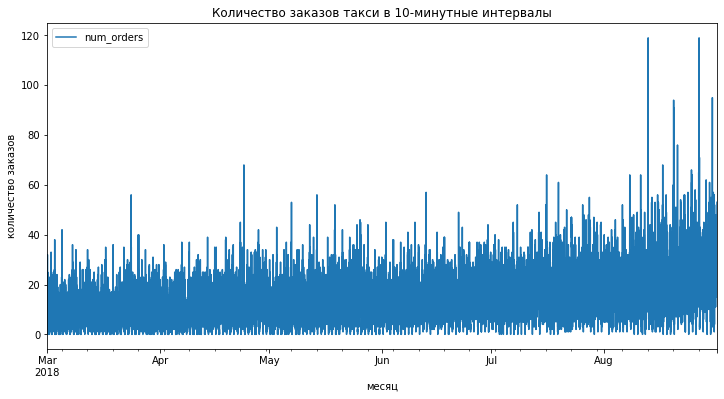

In [ ]:
df.plot(xlabel = 'месяц', ylabel='количество заказов', title = 'Количество заказов такси в 10-минутные интервалы');

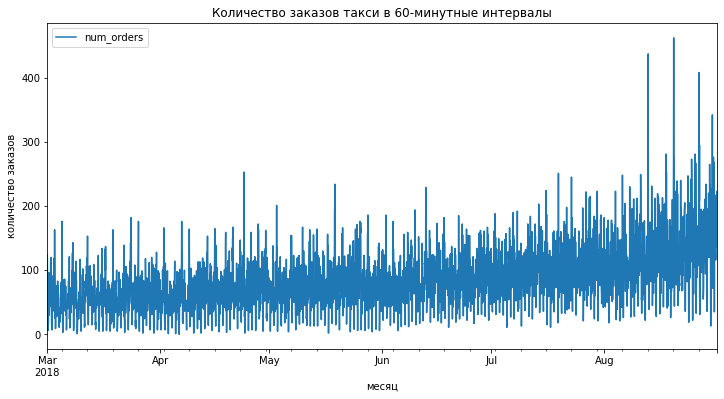

In [ ]:
df = df.resample('1H').sum()
df.plot(xlabel = 'месяц', ylabel='количество заказов', title = 'Количество заказов такси в 60-минутные интервалы');

Видно что примерно с июня начинает расти количество заказов.

## Анализ

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


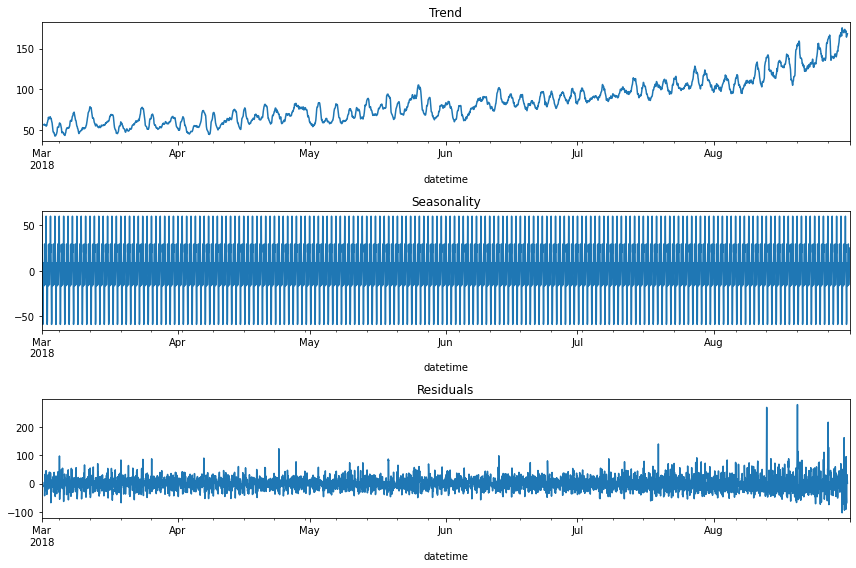

In [ ]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

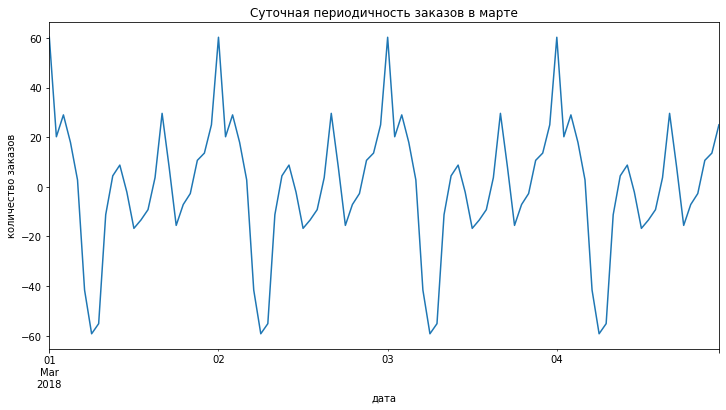

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-04'].plot(ax=plt.gca(), xlabel = 'дата', ylabel='количество заказов', title = 'Суточная периодичность заказов в марте');

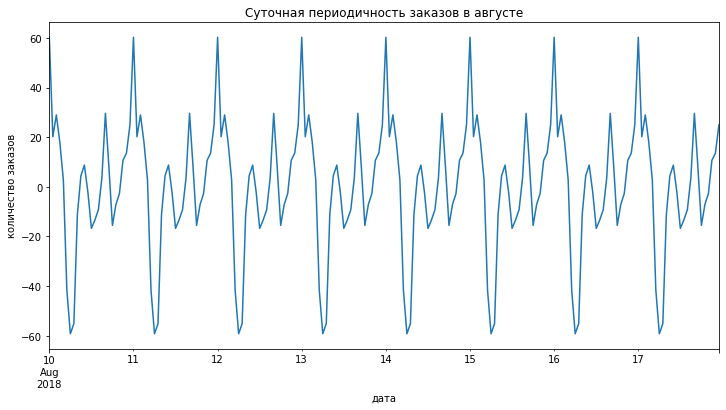

In [ ]:
decomposed.seasonal['2018-08-10':'2018-08-17'].plot(ax=plt.gca(), xlabel = 'дата', ylabel='количество заказов', title = 'Суточная периодичность заказов в августе');

 - Трендовая компонента начинает расти примерно с июня. Возможно на это влияет сезон отпусков.
 - У сезонной компоненты период сутки. Пик - в полночь, минимум - в районе 6 утра.
 - Суточная периодичность возможно обусловлена часами работы общественного транспорта.
 - Компонента остатков видимо увеличивает разброс относительно 0 в середине августа.

Посмотрим на графике разные временые интервалы для скользящего среднего.

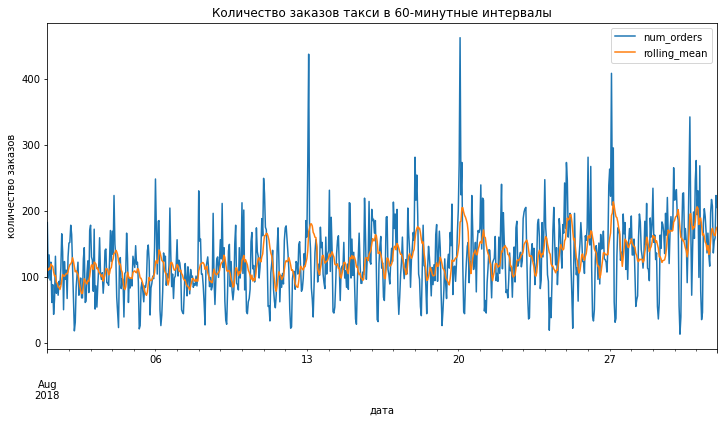

In [ ]:
df2 = df
df2['rolling_mean'] = df2.rolling(10).mean()
df2['2018-08-01':'2018-08-31'].plot(xlabel = 'дата', ylabel='количество заказов', title = 'Количество заказов такси и скользящее среднее 10 дней');

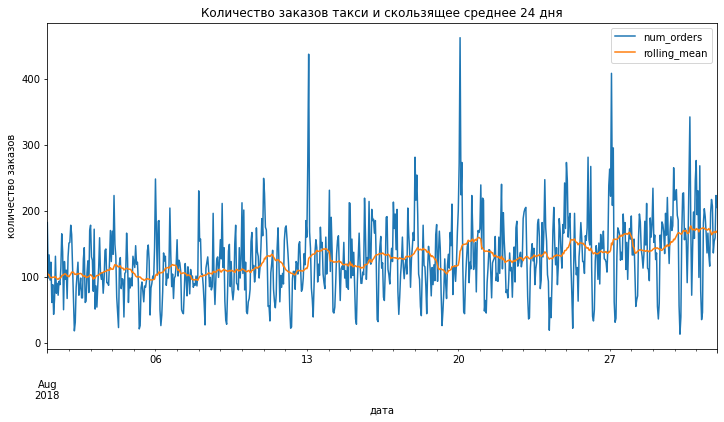

In [ ]:
df3 = df
df3['rolling_mean'] = df3.rolling(24).mean()
df3['2018-08-01':'2018-08-31'].plot(xlabel = 'дата', ylabel='количество заказов', title = 'Количество заказов такси и скользящее среднее 24 дня');

Оценим стационарность ряда.

In [ ]:
df2['rolling_std'] = df2['num_orders'].rolling(10).std()

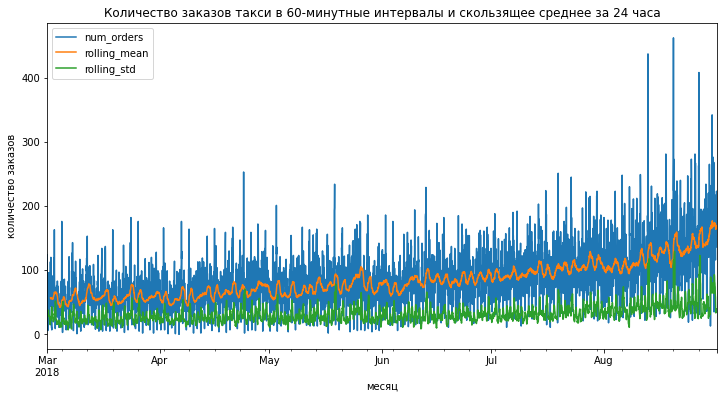

In [ ]:
df2.plot(xlabel = 'месяц', ylabel='количество заказов', title = 'Количество заказов такси в 60-минутные интервалы и скользящее среднее за 24 часа');

 - Судя по растущему скользящему среднему и меняющемуся среднему значению - ряд не стационарный.

 Посмотрим что скажет тест Дики-Фуллера. H0: Временной ряд не стационарен. Уровень значимости возьмем 1%.

In [ ]:
result = adfuller(df2['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


P-значение для временного ряда меньше 1%, и соответственно, нулевая гипотеза отвергнута, а временной ряд нестационарен.

Выполнены подготовка и анализ данных.
 - выделены трендовая и сезонная компоненты временного ряда.
 - оценена стационарность ряда - ряд стационарен.

## Обучение

In [ ]:
#Создам таблицу с RMSE моделей
model = ['DummyRegressor', 'LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
model_rmse = pd.DataFrame(columns=['rmse_'], index=model)

In [ ]:
def rmse(target, predictions):
    predictions = np.array(predictions)
    target = np.array(target)
    return(((target - predictions)**2).mean()**0.5)

In [ ]:
#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    df_c = data.copy()
    #ata['month'] = data.index.month
    df_c['dayofweek'] = df_c.index.dayofweek
    df_c['hour'] = df_c.index.hour

    for lag in range(1, max_lag + 1): #[1, 23, 24]:  #
        df_c['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    df_c['rolling_mean'] = df_c['num_orders'].shift().rolling(rolling_mean_size).mean()

    return df_c

Максимально влияет на количество заказов в час количество заказов в соседний час, час через сутки и через 23 часа, поэтому выберем max_lag = 1, 23, 24.  
При rolling_mean_size = 24 был получен минимальный RMSE (значение выбиралось из 1-6, 12, 24).

In [ ]:
df4 = make_features(df, 24, 24)
df4.head(30)

,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,NaN,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,NaN,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,NaN,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,NaN,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train, test = train_test_split(df4, shuffle=False, test_size=0.1)
print(train.shape)
print(test.shape)

train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

print(train.shape)
print(test.shape)

(3974, 29)
(442, 29)
2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00
(3950, 29)
(442, 29)


In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=7,
    max_train_size=None
)

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### DummyRegressor

In [ ]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)

predict = dummy.predict(features_test)

rmse_dr = rmse(target_test, predict)

print('Средняя оценка качества RMSE константной модели DummyRegressor: %0.2f' % rmse_dr)

model_rmse['rmse_']['DummyRegressor'] = round(rmse_dr,4)

Средняя оценка качества RMSE константной модели DummyRegressor: 84.65


### LinearRegression

In [ ]:
model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

score_lr = abs(cross_val_score(model_lr, features_train, target_train, n_jobs=-1, cv=ts_cv, verbose=10, scoring='neg_root_mean_squared_error').mean())
print('Средняя оценка качества RMSE модели LinearRegression: %0.2f' % score_lr)

model_rmse['rmse_']['LinearRegression'] = round(score_lr,4)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Средняя оценка качества RMSE модели LinearRegression: 26.68


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    6.4s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    6.4s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    6.4s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    6.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    6.5s finished


### DecisionTreeRegressor

In [ ]:
param_dtr = {'max_depth': range(2, 10, 1),
             'min_samples_leaf': range(1, 4, 1),
             'min_samples_split': range(1, 3, 1)}

model_dtr = DecisionTreeRegressor(random_state = RANDOM_STATE)

dtr_rscv = RandomizedSearchCV(estimator=model_dtr, n_iter=7, n_jobs=-1, cv=ts_cv, param_distributions=param_dtr, scoring='neg_root_mean_squared_error',  random_state = RANDOM_STATE, verbose = 2)
dtr_rscv.fit(features_train, target_train)

print(f'Лучшие параметры для модели DecisionTreeRegressor: {dtr_rscv.best_params_}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 7 folds for each of 7 candidates, totalling 49 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s


Лучшие параметры для модели DecisionTreeRegressor: {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}


[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    4.4s finished


In [ ]:
print('Средняя оценка качества RMSE модели DecisionTreeRegressor: %0.2f' % abs(dtr_rscv.best_score_))
model_rmse['rmse_']['DecisionTreeRegressor'] = round(abs(dtr_rscv.best_score_),4)

Средняя оценка качества RMSE модели DecisionTreeRegressor: 30.28


### RandomForestRegressor

In [ ]:
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)

parameters2 = {'n_estimators': range (10, 100, 10),
             'max_depth': range (2, 8, 1),
             'min_samples_leaf': range (1, 4, 1),
             'min_samples_split': range (1, 3, 1)}

rfr_rscv = RandomizedSearchCV(model_rfr, param_distributions=parameters2, cv=ts_cv, n_iter = 7, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state = RANDOM_STATE, verbose = 10)

rfr_rscv.fit(features_train, target_train)

print(f'Лучшие параметры RandomForestRegressor: {rfr_rscv.best_params_}')
print('Средняя оценка качества RMSE: %0.2f' % abs(rfr_rscv.best_score_))

model_rmse['rmse_']['RandomForestRegressor'] = abs(rfr_rscv.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 7 folds for each of 7 candidates, totalling 49 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  31 out of  49 | elapsed:    2.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  36 out of  49 | elapsed:    3.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  41 out of  49 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  46 out of  49 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    5.6s finished


Лучшие параметры RandomForestRegressor: {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7}
Средняя оценка качества RMSE: 24.62


### CatBoostRegressor

In [ ]:
model_cbr = CatBoostRegressor(loss_function="RMSE", random_state = RANDOM_STATE) # iterations=10,

parameters3 = {'depth': range (3, 18, 1),
               'learning_rate': [0.1, 0.2, 0.3, 0.4]}

In [ ]:
cbr_rscv = RandomizedSearchCV(model_cbr, param_distributions=parameters3, n_iter = 7, cv=ts_cv, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state = RANDOM_STATE, verbose = 10)

cbr_rscv.fit(features_train, target_train)

print(f'Лучшие параметры CatBoostRegressor: {cbr_rscv.best_params_}')
print('Средняя оценка качества RMSE: %0.2f' % abs(cbr_rscv.best_score_))

model_rmse['rmse_']['CatBoostRegressor'] = abs(cbr_rscv.best_score_)

Fitting 7 folds for each of 7 candidates, totalling 49 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  31 out of  49 | elapsed:  1.4min remaining:   49.1s
[Parallel(n_jobs=-1)]: Done  36 out of  49 | elapsed:  8.3min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  41 out of  49 | elapsed: 10.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  46 out of  49 | elapsed: 11.4min remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed: 13.1min finished


0:	learn: 36.9765589	total: 144ms	remaining: 2m 24s
1:	learn: 35.5093925	total: 150ms	remaining: 1m 14s
2:	learn: 34.2079311	total: 155ms	remaining: 51.5s
3:	learn: 33.1332520	total: 160ms	remaining: 39.8s
4:	learn: 32.1237342	total: 165ms	remaining: 32.8s
5:	learn: 31.2336228	total: 170ms	remaining: 28.2s
6:	learn: 30.4960875	total: 175ms	remaining: 24.8s
7:	learn: 29.8632110	total: 180ms	remaining: 22.4s
8:	learn: 29.2112423	total: 185ms	remaining: 20.4s
9:	learn: 28.5312038	total: 190ms	remaining: 18.8s
10:	learn: 28.0910030	total: 195ms	remaining: 17.6s
11:	learn: 27.5918856	total: 200ms	remaining: 16.5s
12:	learn: 27.1139354	total: 205ms	remaining: 15.6s
13:	learn: 26.7670599	total: 210ms	remaining: 14.8s
14:	learn: 26.3643096	total: 215ms	remaining: 14.1s
15:	learn: 26.0054326	total: 219ms	remaining: 13.5s
16:	learn: 25.7372508	total: 224ms	remaining: 13s
17:	learn: 25.4430767	total: 229ms	remaining: 12.5s
18:	learn: 25.2299170	total: 234ms	remaining: 12.1s
19:	learn: 24.9711334	

### LGBMRegressor

In [ ]:
param_lgbm = {'n_estimators': range (100, 1000, 10),
           'max_depth': range (3, 18, 1),
           'min_samples_leaf': range (1, 4, 1),
           'learning_rate': [0.1, 0.3, 0.5, 0.7]
          }

model_lgbm = LGBMRegressor(random_state = RANDOM_STATE)

lgbm_rs = RandomizedSearchCV(estimator=model_lgbm, param_distributions={}, n_iter=7, cv=ts_cv, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE, verbose = 10)
lgbm_rs.fit(features_train, target_train)

rmse_lgb = abs(lgbm_rs.best_score_)

print(f'Лучшие параметры LGBMRegressor: {lgbm_rs.best_params_}')
print('RMSE LGBMRegressor: %0.2f' % rmse_lgb)

model_rmse['rmse_']['LGBMRegressor'] = round(rmse_lgb,4)

C:\Users\nat\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=7. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    8.1s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    8.2s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    8.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    8.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    8.5s finished


Лучшие параметры LGBMRegressor: {}
RMSE LGBMRegressor: 23.56


Для `LGBMRegressor` оптимизировали гиперпараметры и оценили модель на кросс-валидации.

In [ ]:
model_rmse

,rmse_
DummyRegressor,84.6499
LinearRegression,26.6831
DecisionTreeRegressor,30.2802
RandomForestRegressor,24.6152
CatBoostRegressor,23.1741
LGBMRegressor,23.5649


Минимальный RMSE получился у трех моделей: CatBoostRegressor, LGBMRegressor и RandomForestRegressor. Для тестирования выберем CatBoostRegressor.

Сформировали итоговое сравнение моделей и выборали лучшую.

## Тестирование

Посчитаем RMSE на тестовой выборке у CatBoostRegressor.

In [ ]:
pred_test_cbr = cbr_rscv.predict(features_test)

print('RMSE CatBoostRegressor на тестовой выборке: %0.2f' % rmse(target_test, pred_test_cbr))

RMSE CatBoostRegressor на тестовой выборке: 40.22


У CatBoostRegressor RMSE < 48, значит можно использовать эту модель для прогнозирования количества заказов такси на следующий час.

 Есть оценка моделей на `test`.

Если использовать только три значения max_lag: 1, 23, 24, то метрика RMSE не сильно увеличится (у LGBMRegressor метрика возрастет до 45, у других моделей почти не изменится), останутся те же 3 модели с RMSE < 48, но время подбора гиперпараметров уменьшится.